In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [54]:
data = pd.read_csv(r'C:/Users/ruonan.ding/Downloads/train_features.csv',
                   encoding="cp1252")

In [4]:
continuousVar = data.describe().columns
categoricalVar = [i for i in data.columns if i not in continuousVar]

In [5]:
for col in data[categoricalVar]:
    print (data[data[col] == 'NONE'].shape[0] / data.shape[0])
    
# data[data['degree'] == 'NONE']

## This means when there is NONE in degree, there is NONE in major.

0.0
0.0
0.0
0.236854
0.532355
0.0


In [6]:
degree_order = {"NONE": 0, "HIGH_SCHOOL": 1, 'BACHELORS': 2, 'MASTERS': 3, 'DOCTORAL': 4}

new =[]
for i in data['degree']:
    if i in degree_order:
        new.append(degree_order[i])

data['new_degree'] = pd.Series(new)
data = data.drop('degree', axis = 1)

In [7]:
print ('number of comapies: %.1f' % len(data['companyId'].factorize()[1]))
print ('number of major: %.1f' % len(data['major'].factorize()[1]))
print ('number of jobType: %.1f' % len(data['jobType'].factorize()[1]))
print ('number of industry: %.1f' % len(data['industry'].factorize()[1]))

number of comapies: 63.0
number of major: 9.0
number of jobType: 8.0
number of industry: 7.0


In [24]:
data.companyId = data.companyId.astype('category').cat.codes
data.major = data.major.astype('category').cat.codes
data.jobType = data.jobType.astype('category').cat.codes
data.industry = data.industry.astype('category').cat.codes

X_full = data.set_index('jobId')

In [8]:
def feature_hashing(data, column_name, n_feature):
    from sklearn.feature_extraction import FeatureHasher
    fh = FeatureHasher(n_features = n_feature, input_type='string')
    hashed_features = fh.fit_transform(data[column_name]).toarray()
    
    hash_name = []
    for i in range(1, n_feature + 1):
        hash_name.append(column_name + str(i))
    return pd.DataFrame(hashed_features, columns = hash_name)

In [14]:
A = pd.concat([feature_hashing(data, 'jobType', 1), 
               feature_hashing(data, 'industry', 1), 
               feature_hashing(data, 'major', 1)], 
              axis = 1)
B = pd.concat([A, feature_hashing(data, 'companyId', 10)], axis = 1)

X_full = pd.concat([data[continuousVar], data['new_degree'], B], axis = 1).set_index(data['jobId'])

In [25]:
X_full.head(15)

,companyId,jobType,major,industry,yearsExperience,milesFromMetropolis,new_degree
jobId,,,,,,,
JOB1362684407687,31,1,6,3,10,83,3
JOB1362684407688,11,0,7,6,3,73,1
JOB1362684407689,48,7,8,3,10,38,4
JOB1362684407690,32,5,2,0,8,17,4
JOB1362684407691,60,7,8,2,8,16,2
JOB1362684407692,7,5,3,2,2,31,4
JOB1362684407693,7,1,7,3,23,24,0
JOB1362684407694,17,4,2,1,9,70,2
JOB1362684407695,13,3,7,1,1,54,1


In [16]:
train_y = pd.read_csv(r'C:/Users/ruonan.ding/Downloads/train_salaries.csv',
                   encoding="cp1252")

In [17]:
y_target = pd.Series(train_y['salary'])

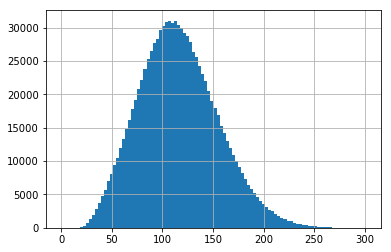

In [18]:
import matplotlib.pyplot as plt
train_y['salary'].hist(bins=100)
plt.show()

In [26]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X_full, y_target, test_size = 0.40, random_state= 30)

In [27]:
from sklearn import ensemble
from sklearn import grid_search
from sklearn.metrics import mean_squared_error

grid_params = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls'}

gbrt = ensemble.GradientBoostingRegressor(**grid_params)

gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=10,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

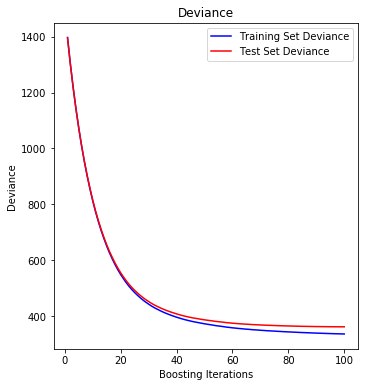

In [28]:
# compute test set deviance
test_score = np.zeros((grid_params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gbrt.staged_predict(X_test)):
    test_score[i] = gbrt.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(grid_params['n_estimators']) + 1, gbrt.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(grid_params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

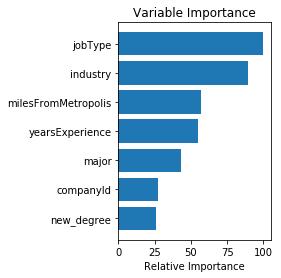

In [29]:
feature_importance = gbrt.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_full.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error
import math

print("RMSE of train GBM: %.4f" % math.sqrt(mean_squared_error(y_train, gbrt.predict(X_train))))
print("RMSE of test GBM: %.4f" % math.sqrt(mean_squared_error(y_test, gbrt.predict(X_test))))
print("R2 of train GBM: %.4f" % gbrt.score(X_train, y_train))
print("R2 of test GBM: %.4f" % gbrt.score(X_test, y_test))

RMSE of train GBM: 18.3204
RMSE of test GBM: 19.0068
R2 of train GBM: 0.7763
R2 of test GBM: 0.7587


In [31]:
from sklearn.externals import joblib
# now you can save it to a file
joblib.dump(gbrt, 'gbrt3.pkl') 

['gbrt3.pkl']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r'C:/Users/ruonan.ding/Downloads/test_features.csv',
                   encoding="cp1252")

In [ ]:
continuousVar = data.describe().columns
categoricalVar = [i for i in data.columns if i not in continuousVar]

In [ ]:
degree_order = {"NONE": 0, "HIGH_SCHOOL": 1, 'BACHELORS': 2, 'MASTERS': 3, 'DOCTORAL': 4}

new =[]
for i in data['degree']:
    if i in degree_order:
        new.append(degree_order[i])

data['new_degree'] = pd.Series(new)
data = data.drop('degree', axis = 1)

data.companyId = data.companyId.astype('category').cat.codes
data.major = data.major.astype('category').cat.codes
data.jobType = data.jobType.astype('category').cat.codes
data.industry = data.industry.astype('category').cat.codes

X_full = data.set_index('jobId')

In [ ]:
data['salary'] = pd.Series(np.round(gbrt.predict(X_full)))

In [ ]:
data[['jobId', 'salary']].to_csv('test_salaries.csv', index = False)